In [118]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import scipy.stats as st
import seaborn as sns
import matplotlib.cm as mplcm
import matplotlib.colors as colors

In [2]:
"""
NOTE: FIPS codes are 5 digit strings for each county in the US
The first two digits are for the state (so each state has a two character code)
#and the last 3 are for the county, but all 5 are used to refer to the county

Virginia FIPS is 51
"""
#To convert between state name representations
state_to_stfips_path ="/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/misc_data/stfips_to_state.csv"
state_to_stfips_df = pd.read_csv(state_to_stfips_path, header=None, dtype={"2":str})
state_to_stfips_df[2] = state_to_stfips_df[2].astype(str).str.zfill(2)
state_to_stfips = state_to_stfips_df.set_index(0)[2].to_dict()
abbr_to_stfips = state_to_stfips_df.set_index(1)[2].to_dict()

#To hold the population of each FIPS
fips_to_pop = pd.read_csv("/project/biocomplexity/COVID-19_commons/2019-nCoV_stat-analyses/misc_data/co-est2019-alldata.csv", encoding="latin-1")
fips_to_pop["fips"] = fips_to_pop.STATE.astype(str).str.zfill(2) + fips_to_pop.COUNTY.astype(str).str.zfill(3).replace("000", "")
fips_to_pop = fips_to_pop.set_index("fips")["POPESTIMATE2019"].to_dict()

#Add some terrotory populations
fips_to_pop["60"] = 55312
fips_to_pop["66"] = 165768
fips_to_pop["69"] = 56882
fips_to_pop["72"] = 2849276
fips_to_pop["78"] = 106977

In [3]:
"""
To get state level cases
"""
state_level_cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/NyTimes/us-states.csv", parse_dates=["date"], dtype={"fips":str})

state_level_cases_cumulative = state_level_cases.pivot(index="date", columns="fips", values="cases")
state_level_cases_incidence = state_level_cases.pivot(index="date", columns="fips", values="cases").diff()

In [4]:
"""
To get county level cases
"""
county_level_cases = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/NyTimes/us-counties.csv", parse_dates=["date"], dtype={"fips":str})

county_level_cases_cumulative = county_level_cases.pivot_table(index="date", columns="fips", values="cases", aggfunc=np.mean)
county_level_cases_incidence = county_level_cases.pivot_table(index="date", columns="fips", values="cases", aggfunc=np.mean).diff()

In [5]:
"""
To convert, e.g. state, cases to cases per 100k population
"""
state_level_cases_incidence_per_100k = state_level_cases_incidence.apply(lambda col: col / (fips_to_pop[col.name] / 100000), axis=0)

In [6]:
"""
To get state level variant samples (by FIPS). One line per sample from GISAID and NCBI, after deduplication of submissions
"""
state_level_variants = pd.read_csv("/project/biocomplexity/COVID-19_commons/data/variants/variant_samples_by_state.csv", parse_dates=["date", "submission_date"], dtype={"state":str})

In [7]:
"""
To get VA variant prevalence, and number of samples, by fortnight
"""
va_variants = state_level_variants[state_level_variants.state == "51"]
va_variants["count"] = 1
va_variants = va_variants.pivot_table(index="date", columns="variant", values="count", aggfunc=sum)
va_variants = va_variants.resample("14D").sum().replace(0, np.nan)
va_variant_prevalence = va_variants.apply(lambda col: col / va_variants.sum(axis=1), axis=0)
va_samples = va_variants.sum(axis=1)

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0.5, 1.0, 'Min Prevalence Detectable')

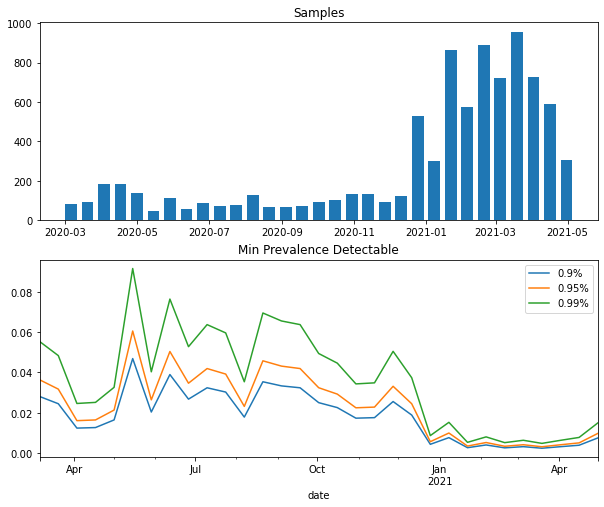

In [40]:
"""
Plot the number of samples, and minimum prevalence detectable with that sample count (Phi from the UT site)
"""

def apply_confidence_bound(col, prob):
    return 1 - (1 - prob)**(1/col)

sample_bounds = pd.DataFrame(va_samples, columns=["samples"])

for confidence in [0.9, 0.95, 0.99]:
    sample_bounds[f"{confidence}%"] = apply_confidence_bound(sample_bounds.samples, confidence)

fig, axs = plt.subplots(2, figsize=(10,8))

axs[0].bar(sample_bounds.index, sample_bounds.samples, width=10)
sample_bounds.drop(columns=["samples"]).plot(ax=axs[1])

axs[0].set_title("Samples")
axs[1].set_title("Min Prevalence Detectable")

### Montgomery and Fairfax Case Studies

Sample size for variant prevalence:
$ sample\_size\_needed = \frac{2z}{Total\_bound} \sqrt{p(1-p)+ \frac{z^2}{4}} $ 

In [24]:
def get_adaptive(path):
    adaptive = pd.read_csv(path, dtype={"id":str})

    adaptive.id = adaptive.id.str.zfill(5)
    adaptive = adaptive.set_index("id")
    adaptive.columns = [np.datetime64("2020-01-23") + np.timedelta64(c) for c in adaptive.columns]
    adaptive = adaptive.T
    adaptive = adaptive[[c for c in adaptive.columns.dropna()]]
    adaptive = adaptive.drop(columns=[c for c in adaptive.columns if "." in c or int(c) == 0])
    return adaptive

In [42]:
infections = "/sfs/qumulo/qproject/biocomplexity/pjp2b/devel/adaptive_SEIR/output_ensemble/v11_ensemble/projections_dev/2021-05-29/51/v1.8_i14_1w/Adaptive/Adaptive_infected_med.csv"
infections = get_adaptive(infections)

In [29]:
# ascertainment = pd.read_csv("/sfs/qumulo/qproject/biocomplexity/COVID-19_commons/data/ascertainment/CDC_ascertainment_with_6_month_waning-2021-06-01.csv", parse_dates=["date"], dtype={"fips":str})
# ascertainment[ascertainment.fips == "51"]

<AxesSubplot:xlabel='date'>

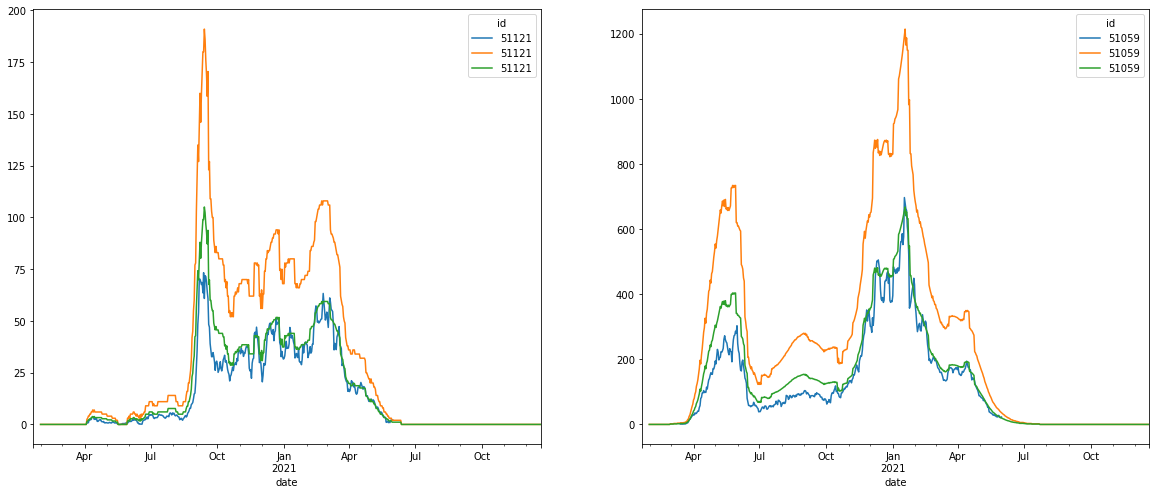

In [159]:
fairfax = "51059"
montgomery = "51121"
loc_map = {fairfax:"Fairfax", montgomery:"Montgomery"}

fairfax_cases = county_level_cases_incidence[[fairfax]]
montgomery_cases = county_level_cases_incidence[[montgomery]]

fig, axs = plt.subplots(1, 2, figsize=(20,8))
montgomery_cases.rolling(7).mean().plot(ax=axs[0], label="cases")
infections[[montgomery]].shift(7).plot(ax=axs[0], label="cases")
(infections[[montgomery]] * 0.55).shift(7).plot(ax=axs[0], label="cases")

fairfax_cases.rolling(7).mean().plot(ax=axs[1], label="cases")
infections[[fairfax]].shift(7).plot(ax=axs[1], label="cases")
(infections[[fairfax]] * 0.55).shift(7).plot(ax=axs[1], label="cases")

In [85]:
asymp=100
symp=150
prev=0.5
confidence=0.95
CI = 0.05
"""
We want the number of samples needed to detect the variant and to estimate the prevalence within a 10% bounds
"""
def calculate_samples_to_detect(prevalence, confidence):
    return math.ceil( math.log(1 - confidence) / math.log(1  - prevalence) )

def calculate_samples_to_estimate(prevalence, confidence, CI_percentage_one_direction):
    alpha = (1 - confidence) / 2
    z_score = st.norm.ppf(1 - alpha)
    b_term = 2 * z_score ** 2 - 4 * ( z_score ** 2 / CI_percentage_one_direction ** 2 ) * prevalence * (1 - prevalence)
    c_term = - ( z_score ** 4 - z_score ** 4 * CI_percentage_one_direction ** 2 ) / (CI_percentage_one_direction ** 2)
    root_1 = (- b_term + (b_term ** 2 - 4 * c_term) ** (1/2) ) / 2
    root_2 = (- b_term - (b_term ** 2 - 4 * c_term) ** (1/2) ) / 2
#     print(root_1, root_2)
    return math.ceil( max(root_1, root_2) )

calculate_samples_to_estimate(0.5, confidence, CI)

1533

In [68]:
3 ** 2 - 2 ** 2 * 2

1

In [49]:
math.log(16, 4)

2.0

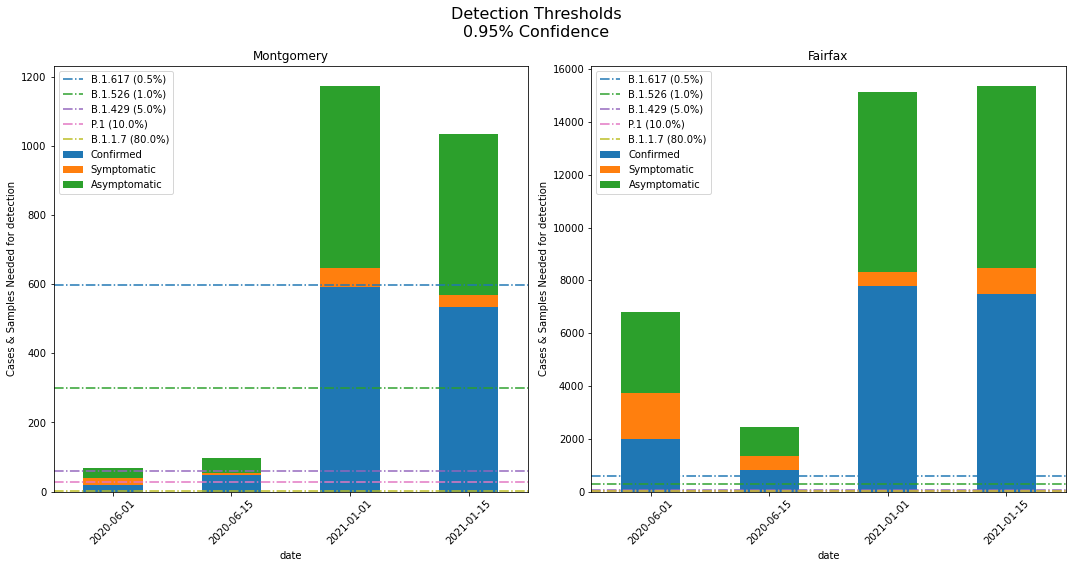

In [181]:
# location = montgomery
CI_tail = 0.05
confidence = 0.95
dates = ["2020-06-01", "2020-06-15", "2021-01-01", "2021-01-15"]
variant_prevalences = {"B.1.617":0.005, "B.1.526":0.01, "B.1.429":0.05, "P.1":0.1, "B.1.1.7":0.8}
cm = plt.get_cmap('tab10')
cNorm  = colors.Normalize(vmin=0, vmax=len(variant_prevalences.keys()))
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
tab_variant_colors = [scalarMap.to_rgba(i) for i in range(len(variant_prevalences.keys()))]
values = "detection" #"detection" or "prevalence estimation"

fig, axs = plt.subplots(1, 2, figsize=(15,8))

for ix, location in enumerate([montgomery, fairfax]):
    date_cases = []
    columns = ['date', 'location', 'variant', 'prevalence', 'detection_samples', 'estimate_samples', 'confidence', 'CI_tail', 'Confirmed', 'Symptomatic', 'Asymptomatic']
    for date in dates:
        date = np.datetime64(date)
        end_date = date + np.timedelta64(14, "D")
        Confirmed = county_level_cases_incidence[[location]].loc[date:end_date].sum().iloc[0]
        Symptomatic = infections[[location]].shift(7).loc[date:end_date].sum().iloc[0] * 0.55
        Asymptomatic = infections[[location]].shift(7).loc[date:end_date].sum().iloc[0] * 0.45    
        date_cases.append((date, location, Confirmed, Symptomatic, Asymptomatic))

    variant_info = []
    for variant, prevalence in variant_prevalences.items():
        detection_samples = calculate_samples_to_detect(prevalence, 0.95)
        estimate_samples = calculate_samples_to_estimate(prevalence, confidence, CI_tail)
        variant_info.append((location, variant, prevalence, detection_samples, estimate_samples, confidence, CI_tail))

    date_df = pd.DataFrame.from_records(date_cases, columns = ["date", "location", "Confirmed", "Symptomatic", "Asymptomatic"])
    variant_df = pd.DataFrame.from_records(variant_info, columns = ['location', 'variant', 'prevalence', 'detection_samples', 'estimate_samples', 'confidence', 'CI_tail'])

    date_df.date = date_df.date.astype(str)
    date_df.Symptomatic = date_df.Symptomatic - date_df.Confirmed
    
    if values.lower() == "detection":
        fig_title = f"Detection Thresholds\n{confidence}% Confidence"
        variant_samples = variant_df.set_index("variant")["detection_samples"].to_dict()
    else:
        fig_title = f"Prevalence Estimation Thresholds\n{confidence*100}% Confidence\nCI Tail of {CI_tail*100}%"
        variant_samples = variant_df.set_index("variant")["estimate_samples"].to_dict()
        
    ax = axs[ix]
    ax.set_prop_cycle(color=tab_variant_colors)

    date_df.set_index("date")[["Confirmed", "Symptomatic", "Asymptomatic"]].drop_duplicates().plot(kind='bar', stacked=True, rot=45, ax=ax)


    ix = 0
    for variant, detection in variant_samples.items():
        ax.axhline(detection, label=f"{variant} ({variant_prevalences[variant]*100}%)", color = tab_variant_colors[ix], linestyle = "-.")
        ix += 1

    ax.legend(loc="upper left")
    ax.set_ylabel(f"Cases & Samples Needed for {values}")
    ax.set_title(loc_map[location])
    
fig.suptitle(fig_title, fontsize=16)
plt.tight_layout()
plt.savefig(f"montgomery_fairfax_{values}.png", dpi=100, bbox_inches="tight", facecolor="white")